# COMP 541 - Deep Learning Course Fall 2020
## Project
### Berk Güler - berkguler20@ku.edu.tr

In [15]:
import Pkg; Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA");
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots
using DelimitedFiles, Statistics, Random
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../Tubitak ANN/DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`


7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

## Data Preprocessing

### Read and Assign all of the data

In [119]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 2 methods)

In [121]:
test_data = Array{Float64}(undef,0,10)
train_data = Array{Float64}(undef,0,10)

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    if participant_index != 5
        for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10     
            train_data = [train_data; time_data raw_data]
        end
    else
        for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
    
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10       
            test_data = [test_data; time_data raw_data]
        end
    end
end

In [122]:
time_history = 25;
ARRAY = Array{Float64}

Array{Float64,N} where N

#### One Hot Encoding

In [123]:
onehot(y) = (m = zeros(eltype(ARRAY),length(y),3); for i in 1:length(y);  m[i,y[i]]=1; end; ARRAY(m))

onehot (generic function with 1 method)

#### Normalizing

In [124]:
function normalize(x)
    return (x .- mean(x,dims=1)) ./ std(x,dims=1);
end

normalize (generic function with 1 method)

In [125]:
x_raw_train = [train_data[:,1] train_data[:,3] train_data[:,4] train_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
x_raw_test  = [train_data[:,1] train_data[:,3] train_data[:,4] train_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
y_train = onehot(convert(Array{Int64},train_data[:,end]));
y_test  = onehot(convert(Array{Int64},test_data[:,end]));

In [126]:
print(size(x_raw_train),size(x_raw_test),size(y_train),size(y_test))

(474619, 4)(474619, 4)(474619, 3)(86220, 3)

#### Sliding Time Window Approach

In [127]:
function slide_time(vector_raw, time_history__)
    X = Array{Float64}(undef,length(vector_raw),time_history__)
    buffer = ones(1,time_history__).*vector_raw[1]
    for i = 1:length(vector_raw)
        X[i,:] = buffer;
        buffer = [buffer[2:end]' vector_raw[i]];
    end
    return X
end

slide_time (generic function with 1 method)

In [132]:
function slide_time_window(x_raw, time_history_) # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
    buffer = ones(1,time_history_)
    time = x_raw[:,1]
    velocity = x_raw[:,2]
    ffint = x_raw[:,3]
    fh = x_raw[:,4]
    velocity_history = slide_time(velocity,time_history_);
    ffint_history = slide_time(ffint,time_history_);
    fh_history = slide_time(fh,time_history_);
    return [time normalize(velocity_history) normalize(velocity) normalize(ffint_history) normalize(ffint) normalize(fh_history) normalize(fh)]
end

slide_time_window (generic function with 1 method)

In [135]:
x_train = slide_time_window(x_raw_train,time_history);
x_test = slide_time_window(x_raw_test,time_history);

## Visualizing the DATA

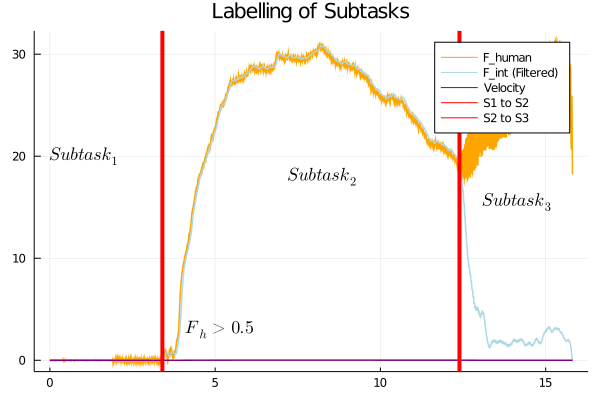

In [197]:
first_x_raw = x_raw_train[1:7907,:]
first_y_raw = train_data[1:7907,end];
sub1_sub2 = findall(x-> 3>x>1,first_y_raw)[1]
sub2_sub3 = findall(x-> x>2,first_y_raw)[1]
plot(first_x_raw[:,1],first_x_raw[:,4], title = "Labelling of Subtasks",  label = "F_human" ,lw = 1.5, fmt = :png, linecolor = "Orange")
plot!(first_x_raw[:,1],first_x_raw[:,3], label= "F_int (Filtered)", lw = 1.5, linecolor="LightBlue")
plot!(first_x_raw[:,1],first_x_raw[:,2], label= "Velocity", lw = 1.5, linecolor="Purple")
plot!([first_x_raw[sub1_sub2,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S1 to S2")
plot!([first_x_raw[sub2_sub3,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S2 to S3")
annotate!(first_x_raw[sub1_sub2,1]+0.7, 3, text("\$F_h > 0.5 \$",Plots.font("Tahoma", 12),  :left))
annotate!(0, 20, text("\$Subtask_1 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub1_sub2,1]+ 3.8, 18, text("\$Subtask_2 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub2_sub3,1]+ 0.7, 15.5, text("\$Subtask_3 \$",Plots.font("Tahoma", 12),  :left))

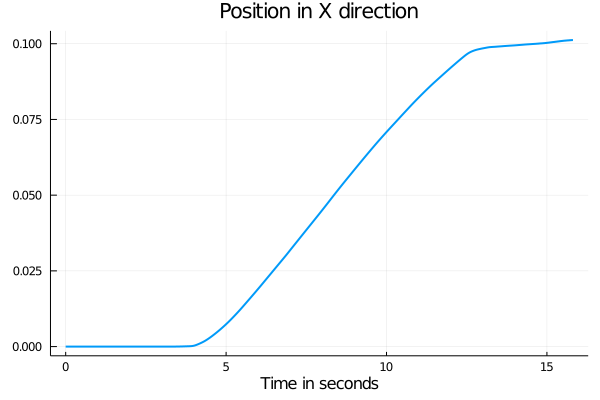

In [204]:
plot(train_data[1:7907,1],train_data[1:7907,2], title = "Position in X direction", label = false, lw = 2)
xlabel!("Time in seconds")

## MLP

### Custom Minibatch Function

In [259]:
function minibatch_custom(x, y, bs=100)
    num, den = divrem(size(x)[1],bs)
    number_of_minibatch = den == 0 ? num : num + 1
    data = Any[]
    nx = size(x)[1]
    ny = size(y)[1]
    for i in 1:bs:nx
        residue = min(bs, size(i:end)[1])
        display(i); display(residue)
        x_mb = x[i:residue,:]
        y_mb = y[i:residue,:]
        
        push!(data,(x_mb,y_mb))
    end

    return data
end

minibatch_custom (generic function with 2 methods)

In [260]:
dtrn = minibatch_custom(x_train,y_train);
dtst = minibatch_custom(x_test,y_test);

1

100

101

100

201

100

301

100

401

100

501

100

601

100

701

100

801

100

901

100

1001

100

1101

100

1201

100

1301

100

1401

100

1501

100

1601

100

1701

100

1801

100

1901

100

2001

100

2101

100

2201

100

2301

100

2401

100

2501

100

2601

100

2701

100

2801

100

2901

100

3001

100

3101

100

3201

100

3301

100

3401

100

3501

100

3601

100

3701

100

3801

100

3901

100

4001

100

4101

100

4201

100

4301

100

4401

100

4501

100

4601

100

4701

100

4801

100

4901

100

5001

100

5101

100

5201

100

5301

100

5401

100

5501

100

5601

100

5701

100

5801

100

5901

100

6001

100

6101

100

6201

100

6301

100

6401

100

6501

100

6601

100

6701

100

6801

100

6901

100

7001

100

7101

100

7201

100

7301

100

7401

100

7501

100

7601

100

7701

100

7801

100

7901

100

8001

100

8101

100

8201

100

8301

100

8401

100

8501

100

8601

100

8701

100

8801

100

8901

100

9001

100

9101

100

9201

100

9301

100

9401

100

9501

100

9601

100

9701

100

9801

100

9901

100

10001

100

10101

100

10201

100

10301

100

10401

100

10501

100

10601

100

10701

100

10801

100

10901

100

11001

100

11101

100

11201

100

11301

100

11401

100

11501

100

11601

100

11701

100

11801

100

11901

100

12001

100

12101

100

12201

100

12301

100

12401

100

12501

100

12601

100

12701

100

12801

100

12901

100

13001

100

13101

100

13201

100

13301

100

13401

100

13501

100

13601

100

13701

100

13801

100

13901

100

14001

100

14101

100

14201

100

14301

100

14401

100

14501

100

14601

100

14701

100

14801

100

14901

100

15001

100

15101

100

15201

100

15301

100

15401

100

15501

100

15601

100

15701

100

15801

100

15901

100

16001

100

16101

100

16201

100

16301

100

16401

100

16501

100

16601

100

16701

100

16801

100

16901

100

17001

100

17101

100

17201

100

17301

100

17401

100

17501

100

17601

100

17701

100

17801

100

17901

100

18001

100

18101

100

18201

100

18301

100

18401

100

18501

100

18601

100

18701

100

18801

100

18901

100

19001

100

19101

100

19201

100

19301

100

19401

100

19501

100

19601

100

19701

100

19801

100

19901

100

20001

100

20101

100

20201

100

20301

100

20401

100

20501

100

20601

100

20701

100

20801

100

20901

100

21001

100

21101

100

21201

100

21301

100

21401

100

21501

100

21601

100

21701

100

21801

100

21901

100

22001

100

22101

100

22201

100

22301

100

22401

100

22501

100

22601

100

22701

100

22801

100

22901

100

23001

100

23101

100

23201

100

23301

100

23401

100

23501

100

23601

100

23701

100

23801

100

23901

100

24001

100

24101

100

24201

100

24301

100

24401

100

24501

100

24601

100

24701

100

24801

100

24901

100

25001

100

25101

100

25201

100

25301

100

25401

100

25501

100

25601

100

25701

100

25801

100

25901

100

26001

100

26101

100

26201

100

26301

100

26401

100

26501

100

26601

100

26701

100

26801

100

26901

100

27001

100

27101

100

27201

100

27301

100

27401

100

27501

100

27601

100

27701

100

27801

100

27901

100

28001

100

28101

100

28201

100

28301

100

28401

100

28501

100

28601

100

28701

100

28801

100

28901

100

29001

100

29101

100

29201

100

29301

100

29401

100

29501

100

29601

100

29701

100

29801

100

29901

100

30001

100

30101

100

30201

100

30301

100

30401

100

30501

100

30601

100

30701

100

30801

100

30901

100

31001

100

31101

100

31201

100

31301

100

31401

100

31501

100

31601

100

31701

100

31801

100

31901

100

32001

100

32101

100

32201

100

32301

100

32401

100

32501

100

32601

100

32701

100

32801

100

32901

100

33001

100

33101

100

33201

100

33301

100

33401

100

33501

100

33601

100

33701

100

33801

100

33901

100

34001

100

34101

100

34201

100

34301

100

34401

100

34501

100

34601

100

34701

100

34801

100

34901

100

35001

100

35101

100

35201

100

35301

100

35401

100

35501

100

35601

100

35701

100

35801

100

35901

100

36001

100

36101

100

36201

100

36301

100

36401

100

36501

100

36601

100

36701

100

36801

100

36901

100

37001

100

37101

100

37201

100

37301

100

37401

100

37501

100

37601

100

37701

100

37801

100

37901

100

38001

100

38101

100

38201

100

38301

100

38401

100

38501

100

38601

100

38701

100

38801

100

38901

100

39001

100

39101

100

39201

100

39301

100

39401

100

39501

100

39601

100

39701

100

39801

100

39901

100

40001

100

40101

100

40201

100

40301

100

40401

100

40501

100

40601

100

40701

100

40801

100

40901

100

41001

100

41101

100

41201

100

41301

100

41401

100

41501

100

41601

100

41701

100

41801

100

41901

100

42001

100

42101

100

42201

100

42301

100

42401

100

42501

100

42601

100

42701

100

42801

100

42901

100

43001

100

43101

100

43201

100

43301

100

43401

100

43501

100

43601

100

43701

100

43801

100

43901

100

44001

100

44101

100

44201

100

44301

100

44401

100

44501

100

44601

100

44701

100

44801

100

44901

100

45001

100

45101

100

45201

100

45301

100

45401

100

45501

100

45601

100

45701

100

45801

100

45901

100

46001

100

46101

100

46201

100

46301

100

46401

100

46501

100

46601

100

46701

100

46801

100

46901

100

47001

100

47101

100

47201

100

47301

100

47401

100

47501

100

47601

100

47701

100

47801

100

47901

100

48001

100

48101

100

48201

100

48301

100

48401

100

48501

100

48601

100

48701

100

48801

100

48901

100

49001

100

49101

100

49201

100

49301

100

49401

100

49501

100

49601

100

49701

100

49801

100

49901

100

50001

100

50101

100

50201

100

50301

100

50401

100

50501

100

50601

100

50701

100

50801

100

50901

100

51001

100

51101

100

51201

100

51301

100

51401

100

51501

100

51601

100

51701

100

51801

100

51901

100

52001

100

52101

100

52201

100

52301

100

52401

100

52501

100

52601

100

52701

100

52801

100

52901

100

53001

100

53101

100

53201

100

53301

100

53401

100

53501

100

53601

100

53701

100

53801

100

53901

100

54001

100

54101

100

54201

100

54301

100

54401

100

54501

100

54601

100

54701

100

54801

100

54901

100

55001

100

55101

100

55201

100

55301

100

55401

100

55501

100

55601

100

55701

100

55801

100

55901

100

56001

100

56101

100

56201

100

56301

100

56401

100

56501

100

56601

100

56701

100

56801

100

56901

100

57001

100

57101

100

57201

100

57301

100

57401

100

57501

100

57601

100

57701

100

57801

100

57901

100

58001

100

58101

100

58201

100

58301

100

58401

100

58501

100

58601

100

58701

100

58801

100

58901

100

59001

100

59101

100

59201

100

59301

100

59401

100

59501

100

59601

100

59701

100

59801

100

59901

100

60001

100

60101

100

60201

100

60301

100

60401

100

60501

100

60601

100

60701

100

60801

100

60901

100

61001

100

61101

100

61201

100

61301

100

61401

100

61501

100

61601

100

61701

100

61801

100

61901

100

62001

100

62101

100

62201

100

62301

100

62401

100

62501

100

62601

100

62701

100

62801

100

62901

100

63001

100

63101

100

63201

100

63301

100

63401

100

63501

100

63601

100

63701

100

63801

100

63901

100

64001

100

64101

100

64201

100

64301

100

64401

100

64501

100

64601

100

64701

100

64801

100

64901

100

65001

100

65101

100

65201

100

65301

100

65401

100

65501

100

65601

100

65701

100

65801

100

65901

100

66001

100

66101

100

66201

100

66301

100

66401

100

66501

100

66601

100

66701

100

66801

100

66901

100

67001

100

67101

100

67201

100

67301

100

67401

100

67501

100

67601

100

67701

100

67801

100

67901

100

68001

100

68101

100

68201

100

68301

100

68401

100

68501

100

68601

100

68701

100

68801

100

68901

100

69001

100

69101

100

69201

100

69301

100

69401

100

69501

100

69601

100

69701

100

69801

100

69901

100

70001

100

70101

100

70201

100

70301

100

70401

100

70501

100

70601

100

70701

100

70801

100

70901

100

71001

100

71101

100

71201

100

71301

100

71401

100

71501

100

71601

100

71701

100

71801

100

71901

100

72001

100

72101

100

72201

100

72301

100

72401

100

72501

100

72601

100

72701

100

72801

100

72901

100

73001

100

73101

100

73201

100

73301

100

73401

100

73501

100

73601

100

73701

100

73801

100

73901

100

74001

100

74101

100

74201

100

74301

100

74401

100

74501

100

74601

100

74701

100

74801

100

74901

100

75001

100

75101

100

75201

100

75301

100

75401

100

75501

100

75601

100

75701

100

75801

100

75901

100

76001

100

76101

100

76201

100

76301

100

76401

100

76501

100

76601

100

76701

100

76801

100

76901

100

77001

100

77101

100

77201

100

77301

100

77401

100

77501

100

77601

100

77701

100

77801

100

77901

100

78001

100

78101

100

78201

100

78301

100

78401

100

78501

100

78601

100

78701

100

78801

100

78901

100

79001

100

79101

100

79201

100

79301

100

79401

100

79501

100

79601

100

79701

100

79801

100

79901

100

80001

100

80101

100

80201

100

80301

100

80401

100

80501

100

80601

100

80701

100

80801

100

80901

100

81001

100

81101

100

81201

100

81301

100

81401

100

81501

100

81601

100

81701

100

81801

100

81901

100

82001

100

82101

100

82201

100

82301

100

82401

100

82501

100

82601

100

82701

100

82801

100

82901

100

83001

100

83101

100

83201

100

83301

100

83401

100

83501

100

83601

100

83701

100

83801

100

83901

100

84001

100

84101

100

84201

100

84301

100

84401

100

84501

100

84601

100

84701

100

84801

100

84901

100

85001

100

85101

100

85201

100

85301

100

85401

100

85501

100

85601

100

85701

100

85801

100

85901

100

86001

100

86101

100

86201

100

86301

100

86401

100

86501

100

86601

100

86701

100

86801

100

86901

100

87001

100

87101

100

87201

100

87301

100

87401

100

87501

100

87601

100

87701

100

87801

100

87901

100

88001

100

88101

100

88201

100

88301

100

88401

100

88501

100

88601

100

88701

100

88801

100

88901

100

89001

100

89101

100

89201

100

89301

100

89401

100

89501

100

89601

100

89701

100

89801

100

89901

100

90001

100

90101

100

90201

100

90301

100

90401

100

90501

100

90601

100

90701

100

90801

100

90901

100

91001

100

91101

100

91201

100

91301

100

91401

100

91501

100

91601

100

91701

100

91801

100

91901

100

92001

100

92101

100

92201

100

92301

100

92401

100

92501

100

92601

100

92701

100

92801

100

92901

100

93001

100

93101

100

93201

100

93301

100

93401

100

93501

100

93601

100

93701

100

93801

100

93901

100

94001

100

94101

100

94201

100

94301

100

94401

100

94501

100

94601

100

94701

100

94801

100

94901

100

95001

100

95101

100

95201

100

95301

100

95401

100

95501

100

95601

100

95701

100

95801

100

95901

100

96001

100

96101

100

96201

100

96301

100

96401

100

96501

100

96601

100

96701

100

96801

100

96901

100

97001

100

97101

100

97201

100

97301

100

97401

100

97501

100

97601

100

97701

100

97801

100

97901

100

98001

100

98101

100

98201

100

98301

100

98401

100

98501

100

98601

100

98701

100

98801

100

98901

100

99001

100

99101

100

99201

100

99301

100

99401

100

99501

100

99601

100

99701

100

99801

100

99901

100

100001

100

100101

100

100201

100

100301

100

100401

100

100501

100

100601

100

100701

100

100801

100

100901

100

101001

100

101101

100

101201

100

101301

100

101401

100

101501

100

101601

100

101701

100

101801

100

101901

100

102001

100

102101

100

102201

100

102301

100

102401

100

102501

100

102601

100

102701

100

102801

100

102901

100

103001

100

103101

100

103201

100

103301

100

103401

100

103501

100

103601

100

103701

100

103801

100

103901

100

104001

100

104101

100

104201

100

104301

100

104401

100

104501

100

104601

100

104701

100

104801

100

104901

100

105001

100

105101

100

105201

100

105301

100

105401

100

105501

100

105601

100

105701

100

105801

100

105901

100

106001

100

106101

100

106201

100

106301

100

106401

100

106501

100

106601

100

106701

100

106801

100

106901

100

107001

100

107101

100

107201

100

107301

100

107401

100

107501

100

107601

100

107701

100

107801

100

107901

100

108001

100

108101

100

108201

100

108301

100

108401

100

108501

100

108601

100

108701

100

108801

100

108901

100

109001

100

109101

100

109201

100

109301

100

109401

100

109501

100

109601

100

109701

100

109801

100

109901

100

110001

100

110101

100

110201

100

110301

100

110401

100

110501

100

110601

100

110701

100

110801

100

110901

100

111001

100

111101

100

111201

100

111301

100

111401

100

111501

100

111601

100

111701

100

111801

100

111901

100

112001

100

112101

100

112201

100

112301

100

112401

100

112501

100

112601

100

112701

100

112801

100

112901

100

113001

100

113101

100

113201

100

113301

100

113401

100

113501

100

113601

100

113701

100

113801

100

113901

100

114001

100

114101

100

114201

100

114301

100

114401

100

114501

100

114601

100

114701

100

114801

100

114901

100

115001

100

115101

100

115201

100

115301

100

115401

100

115501

100

115601

100

115701

100

115801

100

115901

100

116001

100

116101

100

116201

100

116301

100

116401

100

116501

100

116601

100

116701

100

116801

100

116901

100

117001

100

117101

100

117201

100

117301

100

117401

100

117501

100

117601

100

117701

100

117801

100

117901

100

118001

100

118101

100

118201

100

118301

100

118401

100

118501

100

118601

100

118701

100

118801

100

118901

100

119001

100

119101

100

119201

100

119301

100

119401

100

119501

100

119601

100

119701

100

119801

100

119901

100

120001

100

120101

100

120201

100

120301

100

120401

100

120501

100

120601

100

120701

100

120801

100

120901

100

121001

100

121101

100

121201

100

121301

100

121401

100

121501

100

121601

100

121701

100

121801

100

121901

100

122001

100

122101

100

122201

100

122301

100

122401

100

122501

100

122601

100

122701

100

122801

100

122901

100

123001

100

123101

100

123201

100

123301

100

123401

100

123501

100

123601

100

123701

100

123801

100

123901

100

124001

100

124101

100

124201

100

124301

100

124401

100

124501

100

124601

100

124701

100

124801

100

124901

100

125001

100

125101

100

125201

100

125301

100

125401

100

125501

100

125601

100

125701

100

125801

100

125901

100

126001

100

126101

100

126201

100

126301

100

126401

100

126501

100

126601

100

126701

100

126801

100

126901

100

127001

100

127101

100

127201

100

127301

100

127401

100

127501

100

127601

100

127701

100

127801

100

127901

100

128001

100

128101

100

128201

100

128301

100

128401

100

128501

100

128601

100

128701

100

128801

100

128901

100

129001

100

129101

100

129201

100

129301

100

129401

100

129501

100

129601

100

129701

100

129801

100

129901

100

130001

100

130101

100

130201

100

130301

100

130401

100

130501

100

130601

100

130701

100

130801

100

130901

100

131001

100

131101

100

131201

100

131301

100

131401

100

131501

100

131601

100

131701

100

131801

100

131901

100

132001

100

132101

100

132201

100

132301

100

132401

100

132501

100

132601

100

132701

100

132801

100

132901

100

133001

100

133101

100

133201

100

133301

100

133401

100

133501

100

133601

100

133701

100

133801

100

133901

100

134001

100

134101

100

134201

100

134301

100

134401

100

134501

100

134601

100

134701

100

134801

100

134901

100

135001

100

135101

100

135201

100

135301

100

135401

100

135501

100

135601

100

135701

100

135801

100

135901

100

136001

100

136101

100

136201

100

136301

100

136401

100

136501

100

136601

100

136701

100

136801

100

136901

100

137001

100

137101

100

137201

100

137301

100

137401

100

137501

100

137601

100

137701

100

137801

100

137901

100

138001

100

138101

100

138201

100

138301

100

138401

100

138501

100

138601

100

138701

100

138801

100

138901

100

139001

100

139101

100

139201

100

139301

100

139401

100

139501

100

139601

100

139701

100

139801

100

139901

100

140001

100

140101

100

140201

100

140301

100

140401

100

140501

100

140601

100

140701

100

140801

100

140901

100

141001

100

141101

100

141201

100

141301

100

141401

100

141501

100

141601

100

141701

100

141801

100

141901

100

142001

100

142101

100

142201

100

142301

100

142401

100

142501

100

142601

100

142701

100

142801

100

142901

100

143001

100

143101

100

143201

100

143301

100

143401

100

143501

100

143601

100

143701

100

143801

100

143901

100

144001

100

144101

100

144201

100

144301

100

144401

100

144501

100

144601

100

144701

100

144801

100

144901

100

145001

100

145101

100

145201

100

145301

100

145401

100

145501

100

145601

100

145701

100

145801

100

145901

100

146001

100

146101

100

146201

100

146301

100

146401

100

146501

100

146601

100

146701

100

146801

100

146901

100

147001

100

147101

100

147201

100

147301

100

147401

100

147501

100

147601

100

147701

100

147801

100

147901

100

148001

100

148101

100

148201

100

148301

100

148401

100

148501

100

148601

100

148701

100

148801

100

148901

100

149001

100

149101

100

149201

100

149301

100

149401

100

149501

100

149601

100

149701

100

149801

100

149901

100

150001

100

150101

100

150201

100

150301

100

150401

100

150501

100

150601

100

150701

100

150801

100

150901

100

151001

100

151101

100

151201

100

151301

100

151401

100

151501

100

151601

100

151701

100

151801

100

151901

100

152001

100

152101

100

152201

100

152301

100

152401

100

152501

100

152601

100

152701

100

152801

100

152901

100

153001

100

153101

100

153201

100

153301

100

153401

100

153501

100

153601

100

153701

100

153801

100

153901

100

154001

100

154101

100

154201

100

154301

100

154401

100

154501

100

154601

100

154701

100

154801

100

154901

100

155001

100

155101

100

155201

100

155301

100

155401

100

155501

100

155601

100

155701

100

155801

100

155901

100

156001

100

156101

100

156201

100

156301

100

156401

100

156501

100

156601

100

156701

100

156801

100

156901

100

157001

100

157101

100

157201

100

157301

100

157401

100

157501

100

157601

100

157701

100

157801

100

157901

100

158001

100

158101

100

158201

100

158301

100

158401

100

158501

100

158601

100

158701

100

158801

100

158901

100

159001

100

159101

100

159201

100

159301

100

159401

100

159501

100

159601

100

159701

100

159801

100

159901

100

160001

100

160101

100

160201

100

160301

100

160401

100

160501

100

160601

100

160701

100

160801

100

160901

100

161001

100

161101

100

161201

100

161301

100

161401

100

161501

100

161601

100

161701

100

161801

100

161901

100

162001

100

162101

100

162201

100

162301

100

162401

100

162501

100

162601

100

162701

100

162801

100

162901

100

163001

100

163101

100

163201

100

163301

100

163401

100

163501

100

163601

100

163701

100

163801

100

163901

100

164001

100

164101

100

164201

100

164301

100

164401

100

164501

100

164601

100

164701

100

164801

100

164901

100

165001

100

165101

100

165201

100

165301

100

165401

100

165501

100

165601

100

165701

100

165801

100

165901

100

166001

100

166101

100

166201

100

166301

100

166401

100

166501

100

166601

100

166701

100

166801

100

166901

100

167001

100

167101

100

167201

100

167301

100

167401

100

167501

100

167601

100

167701

100

167801

100

167901

100

168001

100

168101

100

168201

100

168301

100

168401

100

168501

100

168601

100

168701

100

168801

100

168901

100

169001

100

169101

100

169201

100

169301

100

169401

100

169501

100

169601

100

169701

100

169801

100

169901

100

170001

100

170101

100

170201

100

170301

100

170401

100

170501

100

170601

100

170701

100

170801

100

170901

100

171001

100

171101

100

171201

100

171301

100

171401

100

171501

100

171601

100

171701

100

171801

100

171901

100

172001

100

172101

100

172201

100

172301

100

172401

100

172501

100

172601

100

172701

100

172801

100

172901

100

173001

100

173101

100

173201

100

173301

100

173401

100

173501

100

173601

100

173701

100

173801

100

173901

100

174001

100

174101

100

174201

100

174301

100

174401

100

174501

100

174601

100

174701

100

174801

100

174901

100

175001

100

175101

100

175201

100

175301

100

175401

100

175501

100

175601

100

175701

100

175801

100

175901

100

176001

100

176101

100

176201

100

176301

100

176401

100

176501

100

176601

100

176701

100

176801

100

176901

100

177001

100

177101

100

177201

100

177301

100

177401

100

177501

100

177601

100

177701

100

177801

100

177901

100

178001

100

178101

100

178201

100

178301

100

178401

100

178501

100

178601

100

178701

100

178801

100

178901

100

179001

100

179101

100

179201

100

179301

100

179401

100

179501

100

179601

100

179701

100

179801

100

179901

100

180001

100

180101

100

180201

100

180301

100

180401

100

180501

100

180601

100

180701

100

180801

100

180901

100

181001

100

181101

100

181201

100

181301

100

181401

100

181501

100

181601

100

181701

100

181801

100

181901

100

182001

100

182101

100

182201

100

182301

100

182401

100

182501

100

182601

100

182701

100

182801

100

182901

100

183001

100

183101

100

183201

100

183301

100

183401

100

183501

100

183601

100

183701

100

183801

100

183901

100

184001

100

184101

100

184201

100

184301

100

184401

100

184501

100

184601

100

184701

100

184801

100

184901

100

185001

100

185101

100

185201

100

185301

100

185401

100

185501

100

185601

100

185701

100

185801

100

185901

100

186001

100

186101

100

186201

100

186301

100

186401

100

186501

100

186601

100

186701

100

186801

100

186901

100

187001

100

187101

100

187201

100

187301

100

187401

100

187501

100

187601

100

187701

100

187801

100

187901

100

188001

100

188101

100

188201

100

188301

100

188401

100

188501

100

188601

100

188701

100

188801

100

188901

100

189001

100

189101

100

189201

100

189301

100

189401

100

189501

100

189601

100

189701

100

189801

100

189901

100

190001

100

190101

100

190201

100

190301

100

190401

100

190501

100

190601

100

190701

100

190801

100

190901

100

191001

100

191101

100

191201

100

191301

100

191401

100

191501

100

191601

100

191701

100

191801

100

191901

100

192001

100

192101

100

192201

100

192301

100

192401

100

192501

100

192601

100

192701

100

192801

100

192901

100

193001

100

193101

100

193201

100

193301

100

193401

100

193501

100

193601

100

193701

100

193801

100

193901

100

194001

100

194101

100

194201

100

194301

100

194401

100

194501

100

194601

100

194701

100

194801

100

194901

100

195001

100

195101

100

195201

100

195301

100

195401

100

195501

100

195601

100

195701

100

195801

100

195901

100

196001

100

196101

100

196201

100

196301

100

196401

100

196501

100

196601

100

196701

100

196801

100

196901

100

197001

100

197101

100

197201

100

197301

100

197401

100

197501

100

197601

100

197701

100

197801

100

197901

100

198001

100

198101

100

198201

100

198301

100

198401

100

198501

100

198601

100

198701

100

198801

100

198901

100

199001

100

199101

100

199201

100

199301

100

199401

100

199501

100

199601

100

199701

100

199801

100

199901

100

200001

100

200101

100

200201

100

200301

100

200401

100

200501

100

200601

100

200701

100

200801

100

200901

100

201001

100

201101

100

201201

100

201301

100

201401

100

201501

100

201601

100

201701

100

201801

100

201901

100

202001

100

202101

100

202201

100

202301

100

202401

100

202501

100

202601

100

202701

100

202801

100

202901

100

203001

100

203101

100

203201

100

203301

100

203401

100

203501

100

203601

100

203701

100

203801

100

203901

100

204001

100

204101

100

204201

100

204301

100

204401

100

204501

100

204601

100

204701

100

204801

100

204901

100

205001

100

205101

100

205201

100

205301

100

205401

100

205501

100

205601

100

205701

100

205801

100

205901

100

206001

100

206101

100

206201

100

206301

100

206401

100

206501

100

206601

100

206701

100

206801

100

206901

100

207001

100

207101

100

207201

100

207301

100

207401

100

207501

100

207601

100

207701

100

207801

100

207901

100

208001

100

208101

100

208201

100

208301

100

208401

100

208501

100

208601

100

208701

100

208801

100

208901

100

209001

100

209101

100

209201

100

209301

100

209401

100

209501

100

209601

100

209701

100

209801

100

209901

100

210001

100

210101

100

210201

100

210301

100

210401

100

210501

100

210601

100

210701

100

210801

100

210901

100

211001

100

211101

100

211201

100

211301

100

211401

100

211501

100

211601

100

211701

100

211801

100

211901

100

212001

100

212101

100

212201

100

212301

100

212401

100

212501

100

212601

100

212701

100

212801

100

212901

100

213001

100

213101

100

213201

100

213301

100

213401

100

213501

100

213601

100

213701

100

213801

100

213901

100

214001

100

214101

100

214201

100

214301

100

214401

100

214501

100

214601

100

214701

100

214801

100

214901

100

215001

100

215101

100

215201

100

215301

100

215401

100

215501

100

215601

100

215701

100

215801

100

215901

100

216001

100

216101

100

216201

100

216301

100

216401

100

216501

100

216601

100

216701

100

216801

100

216901

100

217001

100

217101

100

217201

100

217301

100

217401

100

217501

100

217601

100

217701

100

217801

100

217901

100

218001

100

218101

100

218201

100

218301

100

218401

100

218501

100

218601

100

218701

100

218801

100

218901

100

219001

100

219101

100

219201

100

219301

100

219401

100

219501

100

219601

100

219701

100

219801

100

219901

100

220001

100

220101

100

220201

100

220301

100

220401

100

220501

100

220601

100

220701

100

220801

100

220901

100

221001

100

221101

100

221201

100

221301

100

221401

100

221501

100

221601

100

221701

100

221801

100

221901

100

222001

100

222101

100

222201

100

222301

100

222401

100

222501

100

222601

100

222701

100

222801

100

222901

100

223001

100

223101

100

223201

100

223301

100

223401

100

223501

100

223601

100

223701

100

223801

100

223901

100

224001

100

224101

100

224201

100

224301

100

224401

100

224501

100

224601

100

224701

100

224801

100

224901

100

225001

100

225101

100

225201

100

225301

100

225401

100

225501

100

225601

100

225701

100

225801

100

225901

100

226001

100

226101

100

226201

100

226301

100

226401

100

226501

100

226601

100

226701

100

226801

100

226901

100

227001

100

227101

100

227201

100

227301

100

227401

100

227501

100

227601

100

227701

100

227801

100

227901

100

228001

100

228101

100

228201

100

228301

100

228401

100

228501

100

228601

100

228701

100

228801

100

228901

100

229001

100

229101

100

229201

100

229301

100

229401

100

229501

100

229601

100

229701

100

229801

100

229901

100

230001

100

230101

100

230201

100

230301

100

230401

100

230501

100

230601

100

230701

100

230801

100

230901

100

231001

100

231101

100

231201

100

231301

100

231401

100

231501

100

231601

100

231701

100

231801

100

231901

100

232001

100

232101

100

232201

100

232301

100

232401

100

232501

100

232601

100

232701

100

232801

100

232901

100

233001

100

233101

100

233201

100

233301

100

233401

100

233501

100

233601

100

233701

100

233801

100

233901

100

234001

100

234101

100

234201

100

234301

100

234401

100

234501

100

234601

100

234701

100

234801

100

234901

100

235001

100

235101

100

235201

100

235301

100

235401

100

235501

100

235601

100

235701

100

235801

100

235901

100

236001

100

236101

100

236201

100

236301

100

236401

100

236501

100

236601

100

236701

100

236801

100

236901

100

237001

100

237101

100

237201

100

237301

100

237401

100

237501

100

237601

100

237701

100

237801

100

237901

100

238001

100

238101

100

238201

100

238301

100

238401

100

238501

100

238601

100

238701

100

238801

100

238901

100

239001

100

239101

100

239201

100

239301

100

239401

100

239501

100

239601

100

239701

100

239801

100

239901

100

240001

100

240101

100

240201

100

240301

100

240401

100

240501

100

240601

100

240701

100

240801

100

240901

100

241001

100

241101

100

241201

100

241301

100

241401

100

241501

100

241601

100

241701

100

241801

100

241901

100

242001

100

242101

100

242201

100

242301

100

242401

100

242501

100

242601

100

242701

100

242801

100

242901

100

243001

100

243101

100

243201

100

243301

100

243401

100

243501

100

243601

100

243701

100

243801

100

243901

100

244001

100

244101

100

244201

100

244301

100

244401

100

244501

100

244601

100

244701

100

244801

100

244901

100

245001

100

245101

100

245201

100

245301

100

245401

100

245501

100

245601

100

245701

100

245801

100

245901

100

246001

100

246101

100

246201

100

246301

100

246401

100

246501

100

246601

100

246701

100

246801

100

246901

100

247001

100

247101

100

247201

100

247301

100

247401

100

247501

100

247601

100

247701

100

247801

100

247901

100

248001

100

248101

100

248201

100

248301

100

248401

100

248501

100

248601

100

248701

100

248801

100

248901

100

249001

100

249101

100

249201

100

249301

100

249401

100

249501

100

249601

100

249701

100

249801

100

249901

100

250001

100

250101

100

250201

100

250301

100

250401

100

250501

100

250601

100

250701

100

250801

100

250901

100

251001

100

251101

100

251201

100

251301

100

251401

100

251501

100

251601

100

251701

100

251801

100

251901

100

252001

100

252101

100

252201

100

252301

100

252401

100

252501

100

252601

100

252701

100

252801

100

252901

100

253001

100

253101

100

253201

100

253301

100

253401

100

253501

100

253601

100

253701

100

253801

100

253901

100

254001

100

254101

100

254201

100

254301

100

254401

100

254501

100

254601

100

254701

100

254801

100

254901

100

255001

100

255101

100

255201

100

255301

100

255401

100

255501

100

255601

100

255701

100

255801

100

255901

100

256001

100

256101

100

256201

100

256301

100

256401

100

256501

100

256601

100

256701

100

256801

100

256901

100

257001

100

257101

100

257201

100

257301

100

257401

100

257501

100

257601

100

257701

100

257801

100

257901

100

258001

100

258101

100

258201

100

258301

100

258401

100

258501

100

258601

100

258701

100

258801

100

258901

100

259001

100

259101

100

259201

100

259301

100

259401

100

259501

100

259601

100

259701

100

259801

100

259901

100

260001

100

260101

100

260201

100

260301

100

260401

100

260501

100

260601

100

260701

100

260801

100

260901

100

261001

100

261101

100

261201

100

261301

100

261401

100

261501

100

261601

100

261701

100

261801

100

261901

100

262001

100

262101

100

262201

100

262301

100

262401

100

262501

100

262601

100

262701

100

262801

100

262901

100

263001

100

263101

100

263201

100

263301

100

263401

100

263501

100

263601

100

263701

100

263801

100

263901

100

264001

100

264101

100

264201

100

264301

100

264401

100

264501

100

264601

100

264701

100

264801

100

264901

100

265001

100

265101

100

265201

100

265301

100

265401

100

265501

100

265601

100

265701

100

265801

100

265901

100

266001

100

266101

100

266201

100

266301

100

266401

100

266501

100

266601

100

266701

100

266801

100

266901

100

267001

100

267101

100

267201

100

267301

100

267401

100

267501

100

267601

100

267701

100

267801

100

267901

100

268001

100

268101

100

268201

100

268301

100

268401

100

268501

100

268601

100

268701

100

268801

100

268901

100

269001

100

269101

100

269201

100

269301

100

269401

100

269501

100

269601

100

269701

100

269801

100

269901

100

270001

100

270101

100

270201

100

270301

100

270401

100

270501

100

270601

100

270701

100

270801

100

270901

100

271001

100

271101

100

271201

100

271301

100

271401

100

271501

100

271601

100

271701

100

271801

100

271901

100

272001

100

272101

100

272201

100

272301

100

272401

100

272501

100

272601

100

272701

100

272801

100

272901

100

273001

100

273101

100

273201

100

273301

100

273401

100

273501

100

273601

100

273701

100

273801

100

273901

100

274001

100

274101

100

274201

100

274301

100

274401

100

274501

100

274601

100

274701

100

274801

100

274901

100

275001

100

275101

100

275201

100

275301

100

275401

100

275501

100

275601

100

275701

100

275801

100

275901

100

276001

100

276101

100

276201

100

276301

100

276401

100

276501

100

276601

100

276701

100

276801

100

276901

100

277001

100

277101

100

277201

100

277301

100

277401

100

277501

100

277601

100

277701

100

277801

100

277901

100

278001

100

278101

100

278201

100

278301

100

278401

100

278501

100

278601

100

278701

100

278801

100

278901

100

279001

100

279101

100

279201

100

279301

100

279401

100

279501

100

279601

100

279701

100

279801

100

279901

100

280001

100

280101

100

280201

100

280301

100

280401

100

280501

100

280601

100

280701

100

280801

100

280901

100

281001

100

281101

100

281201

100

281301

100

281401

100

281501

100

281601

100

281701

100

281801

100

281901

100

282001

100

282101

100

282201

100

282301

100

282401

100

282501

100

282601

100

282701

100

282801

100

282901

100

283001

100

283101

100

283201

100

283301

100

283401

100

283501

100

283601

100

283701

100

283801

100

283901

100

284001

100

284101

100

284201

100

284301

100

284401

100

284501

100

284601

100

284701

100

284801

100

284901

100

285001

100

285101

100

285201

100

285301

100

285401

100

285501

100

285601

100

285701

100

285801

100

285901

100

286001

100

286101

100

286201

100

286301

100

286401

100

286501

100

286601

100

286701

100

286801

100

286901

100

287001

100

287101

100

287201

100

287301

100

287401

100

287501

100

287601

100

287701

100

287801

100

287901

100

288001

100

288101

100

288201

100

288301

100

288401

100

288501

100

288601

100

288701

100

288801

100

288901

100

289001

100

289101

100

289201

100

289301

100

289401

100

289501

100

289601

100

289701

100

289801

100

289901

100

290001

100

290101

100

290201

100

290301

100

290401

100

290501

100

290601

100

290701

100

290801

100

290901

100

291001

100

291101

100

291201

100

291301

100

291401

100

291501

100

291601

100

291701

100

291801

100

291901

100

292001

100

292101

100

292201

100

292301

100

292401

100

292501

100

292601

100

292701

100

292801

100

292901

100

293001

100

293101

100

293201

100

293301

100

293401

100

293501

100

293601

100

293701

100

293801

100

293901

100

294001

100

294101

100

294201

100

294301

100

294401

100

294501

100

294601

100

294701

100

294801

100

294901

100

295001

100

295101

100

295201

100

295301

100

295401

100

295501

100

295601

100

295701

100

295801

100

295901

100

296001

100

296101

100

296201

100

296301

100

296401

100

296501

100

296601

100

296701

100

296801

100

296901

100

297001

100

297101

100

297201

100

297301

100

297401

100

297501

100

297601

100

297701

100

297801

100

297901

100

298001

100

298101

100

298201

100

298301

100

298401

100

298501

100

298601

100

298701

100

298801

100

298901

100

299001

100

299101

100

299201

100

299301

100

299401

100

299501

100

299601

100

299701

100

299801

100

299901

100

300001

100

300101

100

300201

100

300301

100

300401

100

300501

100

300601

100

300701

100

300801

100

300901

100

301001

100

301101

100

301201

100

301301

100

301401

100

301501

100

301601

100

301701

100

301801

100

301901

100

302001

100

302101

100

302201

100

302301

100

302401

100

302501

100

302601

100

302701

100

302801

100

302901

100

303001

100

303101

100

303201

100

303301

100

303401

100

303501

100

303601

100

303701

100

303801

100

303901

100

304001

100

304101

100

304201

100

304301

100

304401

100

304501

100

304601

100

304701

100

304801

100

304901

100

305001

100

305101

100

305201

100

305301

100

305401

100

305501

100

305601

100

305701

100

305801

100

305901

100

306001

100

306101

100

306201

100

306301

100

306401

100

306501

100

306601

100

306701

100

306801

100

306901

100

307001

100

307101

100

307201

100

307301

100

307401

100

307501

100

307601

100

307701

100

307801

100

307901

100

308001

100

308101

100

308201

100

308301

100

308401

100

308501

100

308601

100

308701

100

308801

100

308901

100

309001

100

309101

100

309201

100

309301

100

309401

100

309501

100

309601

100

309701

100

309801

100

309901

100

310001

100

310101

100

310201

100

310301

100

310401

100

310501

100

310601

100

310701

100

310801

100

310901

100

311001

100

311101

100

311201

100

311301

100

311401

100

311501

100

311601

100

311701

100

311801

100

311901

100

312001

100

312101

100

312201

100

312301

100

312401

100

312501

100

312601

100

312701

100

312801

100

312901

100

313001

100

313101

100

313201

100

313301

100

313401

100

313501

100

313601

100

313701

100

313801

100

313901

100

314001

100

314101

100

314201

100

314301

100

314401

100

314501

100

314601

100

314701

100

314801

100

314901

100

315001

100

315101

100

315201

100

315301

100

315401

100

315501

100

315601

100

315701

100

315801

100

315901

100

316001

100

316101

100

316201

100

316301

100

316401

100

316501

100

316601

100

316701

100

316801

100

316901

100

317001

100

317101

100

317201

100

317301

100

317401

100

317501

100

317601

100

317701

100

317801

100

317901

100

318001

100

318101

100

318201

100

318301

100

318401

100

318501

100

318601

100

318701

100

318801

100

318901

100

319001

100

319101

100

319201

100

319301

100

319401

100

319501

100

319601

100

319701

100

319801

100

319901

100

320001

100

320101

100

320201

100

320301

100

320401

100

320501

100

320601

100

320701

100

320801

100

320901

100

321001

100

321101

100

321201

100

321301

100

321401

100

321501

100

321601

100

321701

100

321801

100

321901

100

322001

100

322101

100

322201

100

322301

100

322401

100

322501

100

322601

100

322701

100

322801

100

322901

100

323001

100

323101

100

323201

100

323301

100

323401

100

323501

100

323601

100

323701

100

323801

100

323901

100

324001

100

324101

100

324201

100

324301

100

324401

100

324501

100

324601

100

324701

100

324801

100

324901

100

325001

100

325101

100

325201

100

325301

100

325401

100

325501

100

325601

100

325701

100

325801

100

325901

100

326001

100

326101

100

326201

100

326301

100

326401

100

326501

100

326601

100

326701

100

326801

100

326901

100

327001

100

327101

100

327201

100

327301

100

327401

100

327501

100

327601

100

327701

100

327801

100

327901

100

328001

100

328101

100

328201

100

328301

100

328401

100

328501

100

328601

100

328701

100

328801

100

328901

100

329001

100

329101

100

329201

100

329301

100

329401

100

329501

100

329601

100

329701

100

329801

100

329901

100

330001

100

330101

100

330201

100

330301

100

330401

100

330501

100

330601

100

330701

100

330801

100

330901

100

331001

100

331101

100

331201

100

331301

100

331401

100

331501

100

331601

100

331701

100

331801

100

331901

100

332001

100

332101

100

332201

100

332301

100

332401

100

332501

100

332601

100

332701

100

332801

100

332901

100

333001

100

333101

100

333201

100

333301

100

333401

100

333501

100

333601

100

333701

100

333801

100

333901

100

334001

100

334101

100

334201

100

334301

100

334401

100

334501

100

334601

100

334701

100

334801

100

334901

100

335001

100

335101

100

335201

100

335301

100

335401

100

335501

100

335601

100

335701

100

335801

100

335901

100

336001

100

336101

100

336201

100

336301

100

336401

100

336501

100

336601

100

336701

100

336801

100

336901

100

337001

100

337101

100

337201

100

337301

100

337401

100

337501

100

337601

100

337701

100

337801

100

337901

100

338001

100

338101

100

338201

100

338301

100

338401

100

338501

100

338601

100

338701

100

338801

100

338901

100

339001

100

339101

100

339201

100

339301

100

339401

100

339501

100

339601

100

339701

100

339801

100

339901

100

340001

100

340101

100

340201

100

340301

100

340401

100

340501

100

340601

100

340701

100

340801

100

340901

100

341001

100

341101

100

341201

100

341301

100

341401

100

341501

100

341601

100

341701

100

341801

100

341901

100

342001

100

342101

100

342201

100

342301

100

342401

100

342501

100

342601

100

342701

100

342801

100

342901

100

343001

100

343101

100

343201

100

343301

100

343401

100

343501

100

343601

100

343701

100

343801

100

343901

100

344001

100

344101

100

344201

100

344301

100

344401

100

344501

100

344601

100

344701

100

344801

100

344901

100

345001

100

345101

100

345201

100

345301

100

345401

100

345501

100

345601

100

345701

100

345801

100

345901

100

346001

100

346101

100

346201

100

346301

100

346401

100

346501

100

346601

100

346701

100

346801

100

346901

100

347001

100

347101

100

347201

100

347301

100

347401

100

347501

100

347601

100

347701

100

347801

100

347901

100

348001

100

348101

100

348201

100

348301

100

348401

100

348501

100

348601

100

348701

100

348801

100

348901

100

349001

100

349101

100

349201

100

349301

100

349401

100

349501

100

349601

100

349701

100

349801

100

349901

100

350001

100

350101

100

350201

100

350301

100

350401

100

350501

100

350601

100

350701

100

350801

100

350901

100

351001

100

351101

100

351201

100

351301

100

351401

100

351501

100

351601

100

351701

100

351801

100

351901

100

352001

100

352101

100

352201

100

352301

100

352401

100

352501

100

352601

100

352701

100

352801

100

352901

100

353001

100

353101

100

353201

100

353301

100

353401

100

353501

100

353601

100

353701

100

353801

100

353901

100

354001

100

354101

100

354201

100

354301

100

354401

100

354501

100

354601

100

354701

100

354801

100

354901

100

355001

100

355101

100

355201

100

355301

100

355401

100

355501

100

355601

100

355701

100

355801

100

355901

100

356001

100

356101

100

356201

100

356301

100

356401

100

356501

100

356601

100

356701

100

356801

100

356901

100

357001

100

357101

100

357201

100

357301

100

357401

100

357501

100

357601

100

357701

100

357801

100

357901

100

358001

100

358101

100

358201

100

358301

100

358401

100

358501

100

358601

100

358701

100

358801

100

358901

100

359001

100

359101

100

359201

100

359301

100

359401

100

359501

100

359601

100

359701

100

359801

100

359901

100

360001

100

360101

100

360201

100

360301

100

360401

100

360501

100

360601

100

360701

100

360801

100

360901

100

361001

100

361101

100

361201

100

361301

100

361401

100

361501

100

361601

100

361701

100

361801

100

361901

100

362001

100

362101

100

362201

100

362301

100

362401

100

362501

100

362601

100

362701

100

362801

100

362901

100

363001

100

363101

100

363201

100

363301

100

363401

100

363501

100

363601

100

363701

100

363801

100

363901

100

364001

100

364101

100

364201

100

364301

100

364401

100

364501

100

364601

100

364701

100

364801

100

364901

100

365001

100

365101

100

365201

100

365301

100

365401

100

365501

100

365601

100

365701

100

365801

100

365901

100

366001

100

366101

100

366201

100

366301

100

366401

100

366501

100

366601

100

366701

100

366801

100

366901

100

367001

100

367101

100

367201

100

367301

100

367401

100

367501

100

367601

100

367701

100

367801

100

367901

100

368001

100

368101

100

368201

100

368301

100

368401

100

368501

100

368601

100

368701

100

368801

100

368901

100

369001

100

369101

100

369201

100

369301

100

369401

100

369501

100

369601

100

369701

100

369801

100

369901

100

370001

100

370101

100

370201

100

370301

100

370401

100

370501

100

370601

100

370701

100

370801

100

370901

100

371001

100

371101

100

371201

100

371301

100

371401

100

371501

100

371601

100

371701

100

371801

100

371901

100

372001

100

372101

100

372201

100

372301

100

372401

100

372501

100

372601

100

372701

100

372801

100

372901

100

373001

100

373101

100

373201

100

373301

100

373401

100

373501

100

373601

100

373701

100

373801

100

373901

100

374001

100

374101

100

374201

100

374301

100

374401

100

374501

100

374601

100

374701

100

374801

100

374901

100

375001

100

375101

100

375201

100

375301

100

375401

100

375501

100

375601

100

375701

100

375801

100

375901

100

376001

100

376101

100

376201

100

376301

100

376401

100

376501

100

376601

100

376701

100

376801

100

376901

100

377001

100

377101

100

377201

100

377301

100

377401

100

377501

100

377601

100

377701

100

377801

100

377901

100

378001

100

378101

100

378201

100

378301

100

378401

100

378501

100

378601

100

378701

100

378801

100

378901

100

379001

100

379101

100

379201

100

379301

100

379401

100

379501

100

379601

100

379701

100

379801

100

379901

100

380001

100

380101

100

380201

100

380301

100

380401

100

380501

100

380601

100

380701

100

380801

100

380901

100

381001

100

381101

100

381201

100

381301

100

381401

100

381501

100

381601

100

381701

100

381801

100

381901

100

382001

100

382101

100

382201

100

382301

100

382401

100

382501

100

382601

100

382701

100

382801

100

382901

100

383001

100

383101

100

383201

100

383301

100

383401

100

383501

100

383601

100

383701

100

383801

100

383901

100

384001

100

384101

100

384201

100

384301

100

384401

100

384501

100

384601

100

384701

100

384801

100

384901

100

385001

100

385101

100

385201

100

385301

100

385401

100

385501

100

385601

100

385701

100

385801

100

385901

100

386001

100

386101

100

386201

100

386301

100

386401

100

386501

100

386601

100

386701

100

386801

100

386901

100

387001

100

387101

100

387201

100

387301

100

387401

100

387501

100

387601

100

387701

100

387801

100

387901

100

388001

100

388101

100

388201

100

388301

100

388401

100

388501

100

388601

100

388701

100

388801

100

388901

100

389001

100

389101

100

389201

100

389301

100

389401

100

389501

100

389601

100

389701

100

389801

100

389901

100

390001

100

390101

100

390201

100

390301

100

390401

100

390501

100

390601

100

390701

100

390801

100

390901

100

391001

100

391101

100

391201

100

391301

100

391401

100

391501

100

391601

100

391701

100

391801

100

391901

100

392001

100

392101

100

392201

100

392301

100

392401

100

392501

100

392601

100

392701

100

392801

100

392901

100

393001

100

393101

100

393201

100

393301

100

393401

100

393501

100

393601

100

393701

100

393801

100

393901

100

394001

100

394101

100

394201

100

394301

100

394401

100

394501

100

394601

100

394701

100

394801

100

394901

100

395001

100

395101

100

395201

100

395301

100

395401

100

395501

100

395601

100

395701

100

395801

100

395901

100

396001

100

396101

100

396201

100

396301

100

396401

100

396501

100

396601

100

396701

100

396801

100

396901

100

397001

100

397101

100

397201

100

397301

100

397401

100

397501

100

397601

100

397701

100

397801

100

397901

100

398001

100

398101

100

398201

100

398301

100

398401

100

398501

100

398601

100

398701

100

398801

100

398901

100

399001

100

399101

100

399201

100

399301

100

399401

100

399501

100

399601

100

399701

100

399801

100

399901

100

400001

100

400101

100

400201

100

400301

100

400401

100

400501

100

400601

100

400701

100

400801

100

400901

100

401001

100

401101

100

401201

100

401301

100

401401

100

401501

100

401601

100

401701

100

401801

100

401901

100

402001

100

402101

100

402201

100

402301

100

402401

100

402501

100

402601

100

402701

100

402801

100

402901

100

403001

100

403101

100

403201

100

403301

100

403401

100

403501

100

403601

100

403701

100

403801

100

403901

100

404001

100

404101

100

404201

100

404301

100

404401

100

404501

100

404601

100

404701

100

404801

100

404901

100

405001

100

405101

100

405201

100

405301

100

405401

100

405501

100

405601

100

405701

100

405801

100

405901

100

406001

100

406101

100

406201

100

406301

100

406401

100

406501

100

406601

100

406701

100

406801

100

406901

100

407001

100

407101

100

407201

100

407301

100

407401

100

407501

100

407601

100

407701

100

407801

100

407901

100

408001

100

408101

100

408201

100

408301

100

408401

100

408501

100

408601

100

408701

100

408801

100

408901

100

409001

100

409101

100

409201

100

409301

100

409401

100

409501

100

409601

100

409701

100

409801

100

409901

100

410001

100

410101

100

410201

100

410301

100

410401

100

410501

100

410601

100

410701

100

410801

100

410901

100

411001

100

411101

100

411201

100

411301

100

411401

100

411501

100

411601

100

411701

100

411801

100

411901

100

412001

100

412101

100

412201

100

412301

100

412401

100

412501

100

412601

100

412701

100

412801

100

412901

100

413001

100

413101

100

413201

100

413301

100

413401

100

413501

100

413601

100

413701

100

413801

100

413901

100

414001

100

414101

100

414201

100

414301

100

414401

100

414501

100

414601

100

414701

100

414801

100

414901

100

415001

100

415101

100

415201

100

415301

100

415401

100

415501

100

415601

100

415701

100

415801

100

415901

100

416001

100

416101

100

416201

100

416301

100

416401

100

416501

100

416601

100

416701

100

416801

100

416901

100

417001

100

417101

100

417201

100

417301

100

417401

100

417501

100

417601

100

417701

100

417801

100

417901

100

418001

100

418101

100

418201

100

418301

100

418401

100

418501

100

418601

100

418701

100

418801

100

418901

100

419001

100

419101

100

419201

100

419301

100

419401

100

419501

100

419601

100

419701

100

419801

100

419901

100

420001

100

420101

100

420201

100

420301

100

420401

100

420501

100

420601

100

420701

100

420801

100

420901

100

421001

100

421101

100

421201

100

421301

100

421401

100

421501

100

421601

100

421701

100

421801

100

421901

100

422001

100

422101

100

422201

100

422301

100

422401

100

422501

100

422601

100

422701

100

422801

100

422901

100

423001

100

423101

100

423201

100

423301

100

423401

100

423501

100

423601

100

423701

100

423801

100

423901

100

424001

100

424101

100

424201

100

424301

100

424401

100

424501

100

424601

100

424701

100

424801

100

424901

100

425001

100

425101

100

425201

100

425301

100

425401

100

425501

100

425601

100

425701

100

425801

100

425901

100

426001

100

426101

100

426201

100

426301

100

426401

100

426501

100

426601

100

426701

100

426801

100

426901

100

427001

100

427101

100

427201

100

427301

100

427401

100

427501

100

427601

100

427701

100

427801

100

427901

100

428001

100

428101

100

428201

100

428301

100

428401

100

428501

100

428601

100

428701

100

428801

100

428901

100

429001

100

429101

100

429201

100

429301

100

429401

100

429501

100

429601

100

429701

100

429801

100

429901

100

430001

100

430101

100

430201

100

430301

100

430401

100

430501

100

430601

100

430701

100

430801

100

430901

100

431001

100

431101

100

431201

100

431301

100

431401

100

431501

100

431601

100

431701

100

431801

100

431901

100

432001

100

432101

100

432201

100

432301

100

432401

100

432501

100

432601

100

432701

100

432801

100

432901

100

433001

100

433101

100

433201

100

433301

100

433401

100

433501

100

433601

100

433701

100

433801

100

433901

100

434001

100

434101

100

434201

100

434301

100

434401

100

434501

100

434601

100

434701

100

434801

100

434901

100

435001

100

435101

100

435201

100

435301

100

435401

100

435501

100

435601

100

435701

100

435801

100

435901

100

436001

100

436101

100

436201

100

436301

100

436401

100

436501

100

436601

100

436701

100

436801

100

436901

100

437001

100

437101

100

437201

100

437301

100

437401

100

437501

100

437601

100

437701

100

437801

100

437901

100

438001

100

438101

100

438201

100

438301

100

438401

100

438501

100

438601

100

438701

100

438801

100

438901

100

439001

100

439101

100

439201

100

439301

100

439401

100

439501

100

439601

100

439701

100

439801

100

439901

100

440001

100

440101

100

440201

100

440301

100

440401

100

440501

100

440601

100

440701

100

440801

100

440901

100

441001

100

441101

100

441201

100

441301

100

441401

100

441501

100

441601

100

441701

100

441801

100

441901

100

442001

100

442101

100

442201

100

442301

100

442401

100

442501

100

442601

100

442701

100

442801

100

442901

100

443001

100

443101

100

443201

100

443301

100

443401

100

443501

100

443601

100

443701

100

443801

100

443901

100

444001

100

444101

100

444201

100

444301

100

444401

100

444501

100

444601

100

444701

100

444801

100

444901

100

445001

100

445101

100

445201

100

445301

100

445401

100

445501

100

445601

100

445701

100

445801

100

445901

100

446001

100

446101

100

446201

100

446301

100

446401

100

446501

100

446601

100

446701

100

446801

100

446901

100

447001

100

447101

100

447201

100

447301

100

447401

100

447501

100

447601

100

447701

100

447801

100

447901

100

448001

100

448101

100

448201

100

448301

100

448401

100

448501

100

448601

100

448701

100

448801

100

448901

100

449001

100

449101

100

449201

100

449301

100

449401

100

449501

100

449601

100

449701

100

449801

100

449901

100

450001

100

450101

100

450201

100

450301

100

450401

100

450501

100

450601

100

450701

100

450801

100

450901

100

451001

100

451101

100

451201

100

451301

100

451401

100

451501

100

451601

100

451701

100

451801

100

451901

100

452001

100

452101

100

452201

100

452301

100

452401

100

452501

100

452601

100

452701

100

452801

100

452901

100

453001

100

453101

100

453201

100

453301

100

453401

100

453501

100

453601

100

453701

100

453801

100

453901

100

454001

100

454101

100

454201

100

454301

100

454401

100

454501

100

454601

100

454701

100

454801

100

454901

100

455001

100

455101

100

455201

100

455301

100

455401

100

455501

100

455601

100

455701

100

455801

100

455901

100

456001

100

456101

100

456201

100

456301

100

456401

100

456501

100

456601

100

456701

100

456801

100

456901

100

457001

100

457101

100

457201

100

457301

100

457401

100

457501

100

457601

100

457701

100

457801

100

457901

100

458001

100

458101

100

458201

100

458301

100

458401

100

458501

100

458601

100

458701

100

458801

100

458901

100

459001

100

459101

100

459201

100

459301

100

459401

100

459501

100

459601

100

459701

100

459801

100

459901

100

460001

100

460101

100

460201

100

460301

100

460401

100

460501

100

460601

100

460701

100

460801

100

460901

100

461001

100

461101

100

461201

100

461301

100

461401

100

461501

100

461601

100

461701

100

461801

100

461901

100

462001

100

462101

100

462201

100

462301

100

462401

100

462501

100

462601

100

462701

100

462801

100

462901

100

463001

100

463101

100

463201

100

463301

100

463401

100

463501

100

463601

100

463701

100

463801

100

463901

100

464001

100

464101

100

464201

100

464301

100

464401

100

464501

100

464601

100

464701

100

464801

100

464901

100

465001

100

465101

100

465201

100

465301

100

465401

100

465501

100

465601

100

465701

100

465801

100

465901

100

466001

100

466101

100

466201

100

466301

100

466401

100

466501

100

466601

100

466701

100

466801

100

466901

100

467001

100

467101

100

467201

100

467301

100

467401

100

467501

100

467601

100

467701

100

467801

100

467901

100

468001

100

468101

100

468201

100

468301

100

468401

100

468501

100

468601

100

468701

100

468801

100

468901

100

469001

100

469101

100

469201

100

469301

100

469401

100

469501

100

469601

100

469701

100

469801

100

469901

100

470001

100

470101

100

470201

100

470301

100

470401

100

470501

100

470601

100

470701

100

470801

100

470901

100

471001

100

471101

100

471201

100

471301

100

471401

100

471501

100

471601

100

471701

100

471801

100

471901

100

472001

100

472101

100

472201

100

472301

100

472401

100

472501

100

472601

100

472701

100

472801

100

472901

100

473001

100

473101

100

473201

100

473301

100

473401

100

473501

100

473601

100

473701

100

473801

100

473901

100

474001

100

474101

100

474201

100

474301

100

474401

100

474501

100

474601

100

1

100

101

100

201

100

301

100

401

100

501

100

601

100

701

100

801

100

901

100

1001

100

1101

100

1201

100

1301

100

1401

100

1501

100

1601

100

1701

100

1801

100

1901

100

2001

100

2101

100

2201

100

2301

100

2401

100

2501

100

2601

100

2701

100

2801

100

2901

100

3001

100

3101

100

3201

100

3301

100

3401

100

3501

100

3601

100

3701

100

3801

100

3901

100

4001

100

4101

100

4201

100

4301

100

4401

100

4501

100

4601

100

4701

100

4801

100

4901

100

5001

100

5101

100

5201

100

5301

100

5401

100

5501

100

5601

100

5701

100

5801

100

5901

100

6001

100

6101

100

6201

100

6301

100

6401

100

6501

100

6601

100

6701

100

6801

100

6901

100

7001

100

7101

100

7201

100

7301

100

7401

100

7501

100

7601

100

7701

100

7801

100

7901

100

8001

100

8101

100

8201

100

8301

100

8401

100

8501

100

8601

100

8701

100

8801

100

8901

100

9001

100

9101

100

9201

100

9301

100

9401

100

9501

100

9601

100

9701

100

9801

100

9901

100

10001

100

10101

100

10201

100

10301

100

10401

100

10501

100

10601

100

10701

100

10801

100

10901

100

11001

100

11101

100

11201

100

11301

100

11401

100

11501

100

11601

100

11701

100

11801

100

11901

100

12001

100

12101

100

12201

100

12301

100

12401

100

12501

100

12601

100

12701

100

12801

100

12901

100

13001

100

13101

100

13201

100

13301

100

13401

100

13501

100

13601

100

13701

100

13801

100

13901

100

14001

100

14101

100

14201

100

14301

100

14401

100

14501

100

14601

100

14701

100

14801

100

14901

100

15001

100

15101

100

15201

100

15301

100

15401

100

15501

100

15601

100

15701

100

15801

100

15901

100

16001

100

16101

100

16201

100

16301

100

16401

100

16501

100

16601

100

16701

100

16801

100

16901

100

17001

100

17101

100

17201

100

17301

100

17401

100

17501

100

17601

100

17701

100

17801

100

17901

100

18001

100

18101

100

18201

100

18301

100

18401

100

18501

100

18601

100

18701

100

18801

100

18901

100

19001

100

19101

100

19201

100

19301

100

19401

100

19501

100

19601

100

19701

100

19801

100

19901

100

20001

100

20101

100

20201

100

20301

100

20401

100

20501

100

20601

100

20701

100

20801

100

20901

100

21001

100

21101

100

21201

100

21301

100

21401

100

21501

100

21601

100

21701

100

21801

100

21901

100

22001

100

22101

100

22201

100

22301

100

22401

100

22501

100

22601

100

22701

100

22801

100

22901

100

23001

100

23101

100

23201

100

23301

100

23401

100

23501

100

23601

100

23701

100

23801

100

23901

100

24001

100

24101

100

24201

100

24301

100

24401

100

24501

100

24601

100

24701

100

24801

100

24901

100

25001

100

25101

100

25201

100

25301

100

25401

100

25501

100

25601

100

25701

100

25801

100

25901

100

26001

100

26101

100

26201

100

26301

100

26401

100

26501

100

26601

100

26701

100

26801

100

26901

100

27001

100

27101

100

27201

100

27301

100

27401

100

27501

100

27601

100

27701

100

27801

100

27901

100

28001

100

28101

100

28201

100

28301

100

28401

100

28501

100

28601

100

28701

100

28801

100

28901

100

29001

100

29101

100

29201

100

29301

100

29401

100

29501

100

29601

100

29701

100

29801

100

29901

100

30001

100

30101

100

30201

100

30301

100

30401

100

30501

100

30601

100

30701

100

30801

100

30901

100

31001

100

31101

100

31201

100

31301

100

31401

100

31501

100

31601

100

31701

100

31801

100

31901

100

32001

100

32101

100

32201

100

32301

100

32401

100

32501

100

32601

100

32701

100

32801

100

32901

100

33001

100

33101

100

33201

100

33301

100

33401

100

33501

100

33601

100

33701

100

33801

100

33901

100

34001

100

34101

100

34201

100

34301

100

34401

100

34501

100

34601

100

34701

100

34801

100

34901

100

35001

100

35101

100

35201

100

35301

100

35401

100

35501

100

35601

100

35701

100

35801

100

35901

100

36001

100

36101

100

36201

100

36301

100

36401

100

36501

100

36601

100

36701

100

36801

100

36901

100

37001

100

37101

100

37201

100

37301

100

37401

100

37501

100

37601

100

37701

100

37801

100

37901

100

38001

100

38101

100

38201

100

38301

100

38401

100

38501

100

38601

100

38701

100

38801

100

38901

100

39001

100

39101

100

39201

100

39301

100

39401

100

39501

100

39601

100

39701

100

39801

100

39901

100

40001

100

40101

100

40201

100

40301

100

40401

100

40501

100

40601

100

40701

100

40801

100

40901

100

41001

100

41101

100

41201

100

41301

100

41401

100

41501

100

41601

100

41701

100

41801

100

41901

100

42001

100

42101

100

42201

100

42301

100

42401

100

42501

100

42601

100

42701

100

42801

100

42901

100

43001

100

43101

100

43201

100

43301

100

43401

100

43501

100

43601

100

43701

100

43801

100

43901

100

44001

100

44101

100

44201

100

44301

100

44401

100

44501

100

44601

100

44701

100

44801

100

44901

100

45001

100

45101

100

45201

100

45301

100

45401

100

45501

100

45601

100

45701

100

45801

100

45901

100

46001

100

46101

100

46201

100

46301

100

46401

100

46501

100

46601

100

46701

100

46801

100

46901

100

47001

100

47101

100

47201

100

47301

100

47401

100

47501

100

47601

100

47701

100

47801

100

47901

100

48001

100

48101

100

48201

100

48301

100

48401

100

48501

100

48601

100

48701

100

48801

100

48901

100

49001

100

49101

100

49201

100

49301

100

49401

100

49501

100

49601

100

49701

100

49801

100

49901

100

50001

100

50101

100

50201

100

50301

100

50401

100

50501

100

50601

100

50701

100

50801

100

50901

100

51001

100

51101

100

51201

100

51301

100

51401

100

51501

100

51601

100

51701

100

51801

100

51901

100

52001

100

52101

100

52201

100

52301

100

52401

100

52501

100

52601

100

52701

100

52801

100

52901

100

53001

100

53101

100

53201

100

53301

100

53401

100

53501

100

53601

100

53701

100

53801

100

53901

100

54001

100

54101

100

54201

100

54301

100

54401

100

54501

100

54601

100

54701

100

54801

100

54901

100

55001

100

55101

100

55201

100

55301

100

55401

100

55501

100

55601

100

55701

100

55801

100

55901

100

56001

100

56101

100

56201

100

56301

100

56401

100

56501

100

56601

100

56701

100

56801

100

56901

100

57001

100

57101

100

57201

100

57301

100

57401

100

57501

100

57601

100

57701

100

57801

100

57901

100

58001

100

58101

100

58201

100

58301

100

58401

100

58501

100

58601

100

58701

100

58801

100

58901

100

59001

100

59101

100

59201

100

59301

100

59401

100

59501

100

59601

100

59701

100

59801

100

59901

100

60001

100

60101

100

60201

100

60301

100

60401

100

60501

100

60601

100

60701

100

60801

100

60901

100

61001

100

61101

100

61201

100

61301

100

61401

100

61501

100

61601

100

61701

100

61801

100

61901

100

62001

100

62101

100

62201

100

62301

100

62401

100

62501

100

62601

100

62701

100

62801

100

62901

100

63001

100

63101

100

63201

100

63301

100

63401

100

63501

100

63601

100

63701

100

63801

100

63901

100

64001

100

64101

100

64201

100

64301

100

64401

100

64501

100

64601

100

64701

100

64801

100

64901

100

65001

100

65101

100

65201

100

65301

100

65401

100

65501

100

65601

100

65701

100

65801

100

65901

100

66001

100

66101

100

66201

100

66301

100

66401

100

66501

100

66601

100

66701

100

66801

100

66901

100

67001

100

67101

100

67201

100

67301

100

67401

100

67501

100

67601

100

67701

100

67801

100

67901

100

68001

100

68101

100

68201

100

68301

100

68401

100

68501

100

68601

100

68701

100

68801

100

68901

100

69001

100

69101

100

69201

100

69301

100

69401

100

69501

100

69601

100

69701

100

69801

100

69901

100

70001

100

70101

100

70201

100

70301

100

70401

100

70501

100

70601

100

70701

100

70801

100

70901

100

71001

100

71101

100

71201

100

71301

100

71401

100

71501

100

71601

100

71701

100

71801

100

71901

100

72001

100

72101

100

72201

100

72301

100

72401

100

72501

100

72601

100

72701

100

72801

100

72901

100

73001

100

73101

100

73201

100

73301

100

73401

100

73501

100

73601

100

73701

100

73801

100

73901

100

74001

100

74101

100

74201

100

74301

100

74401

100

74501

100

74601

100

74701

100

74801

100

74901

100

75001

100

75101

100

75201

100

75301

100

75401

100

75501

100

75601

100

75701

100

75801

100

75901

100

76001

100

76101

100

76201

100

76301

100

76401

100

76501

100

76601

100

76701

100

76801

100

76901

100

77001

100

77101

100

77201

100

77301

100

77401

100

77501

100

77601

100

77701

100

77801

100

77901

100

78001

100

78101

100

78201

100

78301

100

78401

100

78501

100

78601

100

78701

100

78801

100

78901

100

79001

100

79101

100

79201

100

79301

100

79401

100

79501

100

79601

100

79701

100

79801

100

79901

100

80001

100

80101

100

80201

100

80301

100

80401

100

80501

100

80601

100

80701

100

80801

100

80901

100

81001

100

81101

100

81201

100

81301

100

81401

100

81501

100

81601

100

81701

100

81801

100

81901

100

82001

100

82101

100

82201

100

82301

100

82401

100

82501

100

82601

100

82701

100

82801

100

82901

100

83001

100

83101

100

83201

100

83301

100

83401

100

83501

100

83601

100

83701

100

83801

100

83901

100

84001

100

84101

100

84201

100

84301

100

84401

100

84501

100

84601

100

84701

100

84801

100

84901

100

85001

100

85101

100

85201

100

85301

100

85401

100

85501

100

85601

100

85701

100

85801

100

85901

100

86001

100

86101

100

86201

100

86301

100

86401

100

86501

100

86601

100

86701

100

86801

100

86901

100

87001

100

87101

100

87201

100

87301

100

87401

100

87501

100

87601

100

87701

100

87801

100

87901

100

88001

100

88101

100

88201

100

88301

100

88401

100

88501

100

88601

100

88701

100

88801

100

88901

100

89001

100

89101

100

89201

100

89301

100

89401

100

89501

100

89601

100

89701

100

89801

100

89901

100

90001

100

90101

100

90201

100

90301

100

90401

100

90501

100

90601

100

90701

100

90801

100

90901

100

91001

100

91101

100

91201

100

91301

100

91401

100

91501

100

91601

100

91701

100

91801

100

91901

100

92001

100

92101

100

92201

100

92301

100

92401

100

92501

100

92601

100

92701

100

92801

100

92901

100

93001

100

93101

100

93201

100

93301

100

93401

100

93501

100

93601

100

93701

100

93801

100

93901

100

94001

100

94101

100

94201

100

94301

100

94401

100

94501

100

94601

100

94701

100

94801

100

94901

100

95001

100

95101

100

95201

100

95301

100

95401

100

95501

100

95601

100

95701

100

95801

100

95901

100

96001

100

96101

100

96201

100

96301

100

96401

100

96501

100

96601

100

96701

100

96801

100

96901

100

97001

100

97101

100

97201

100

97301

100

97401

100

97501

100

97601

100

97701

100

97801

100

97901

100

98001

100

98101

100

98201

100

98301

100

98401

100

98501

100

98601

100

98701

100

98801

100

98901

100

99001

100

99101

100

99201

100

99301

100

99401

100

99501

100

99601

100

99701

100

99801

100

99901

100

100001

100

100101

100

100201

100

100301

100

100401

100

100501

100

100601

100

100701

100

100801

100

100901

100

101001

100

101101

100

101201

100

101301

100

101401

100

101501

100

101601

100

101701

100

101801

100

101901

100

102001

100

102101

100

102201

100

102301

100

102401

100

102501

100

102601

100

102701

100

102801

100

102901

100

103001

100

103101

100

103201

100

103301

100

103401

100

103501

100

103601

100

103701

100

103801

100

103901

100

104001

100

104101

100

104201

100

104301

100

104401

100

104501

100

104601

100

104701

100

104801

100

104901

100

105001

100

105101

100

105201

100

105301

100

105401

100

105501

100

105601

100

105701

100

105801

100

105901

100

106001

100

106101

100

106201

100

106301

100

106401

100

106501

100

106601

100

106701

100

106801

100

106901

100

107001

100

107101

100

107201

100

107301

100

107401

100

107501

100

107601

100

107701

100

107801

100

107901

100

108001

100

108101

100

108201

100

108301

100

108401

100

108501

100

108601

100

108701

100

108801

100

108901

100

109001

100

109101

100

109201

100

109301

100

109401

100

109501

100

109601

100

109701

100

109801

100

109901

100

110001

100

110101

100

110201

100

110301

100

110401

100

110501

100

110601

100

110701

100

110801

100

110901

100

111001

100

111101

100

111201

100

111301

100

111401

100

111501

100

111601

100

111701

100

111801

100

111901

100

112001

100

112101

100

112201

100

112301

100

112401

100

112501

100

112601

100

112701

100

112801

100

112901

100

113001

100

113101

100

113201

100

113301

100

113401

100

113501

100

113601

100

113701

100

113801

100

113901

100

114001

100

114101

100

114201

100

114301

100

114401

100

114501

100

114601

100

114701

100

114801

100

114901

100

115001

100

115101

100

115201

100

115301

100

115401

100

115501

100

115601

100

115701

100

115801

100

115901

100

116001

100

116101

100

116201

100

116301

100

116401

100

116501

100

116601

100

116701

100

116801

100

116901

100

117001

100

117101

100

117201

100

117301

100

117401

100

117501

100

117601

100

117701

100

117801

100

117901

100

118001

100

118101

100

118201

100

118301

100

118401

100

118501

100

118601

100

118701

100

118801

100

118901

100

119001

100

119101

100

119201

100

119301

100

119401

100

119501

100

119601

100

119701

100

119801

100

119901

100

120001

100

120101

100

120201

100

120301

100

120401

100

120501

100

120601

100

120701

100

120801

100

120901

100

121001

100

121101

100

121201

100

121301

100

121401

100

121501

100

121601

100

121701

100

121801

100

121901

100

122001

100

122101

100

122201

100

122301

100

122401

100

122501

100

122601

100

122701

100

122801

100

122901

100

123001

100

123101

100

123201

100

123301

100

123401

100

123501

100

123601

100

123701

100

123801

100

123901

100

124001

100

124101

100

124201

100

124301

100

124401

100

124501

100

124601

100

124701

100

124801

100

124901

100

125001

100

125101

100

125201

100

125301

100

125401

100

125501

100

125601

100

125701

100

125801

100

125901

100

126001

100

126101

100

126201

100

126301

100

126401

100

126501

100

126601

100

126701

100

126801

100

126901

100

127001

100

127101

100

127201

100

127301

100

127401

100

127501

100

127601

100

127701

100

127801

100

127901

100

128001

100

128101

100

128201

100

128301

100

128401

100

128501

100

128601

100

128701

100

128801

100

128901

100

129001

100

129101

100

129201

100

129301

100

129401

100

129501

100

129601

100

129701

100

129801

100

129901

100

130001

100

130101

100

130201

100

130301

100

130401

100

130501

100

130601

100

130701

100

130801

100

130901

100

131001

100

131101

100

131201

100

131301

100

131401

100

131501

100

131601

100

131701

100

131801

100

131901

100

132001

100

132101

100

132201

100

132301

100

132401

100

132501

100

132601

100

132701

100

132801

100

132901

100

133001

100

133101

100

133201

100

133301

100

133401

100

133501

100

133601

100

133701

100

133801

100

133901

100

134001

100

134101

100

134201

100

134301

100

134401

100

134501

100

134601

100

134701

100

134801

100

134901

100

135001

100

135101

100

135201

100

135301

100

135401

100

135501

100

135601

100

135701

100

135801

100

135901

100

136001

100

136101

100

136201

100

136301

100

136401

100

136501

100

136601

100

136701

100

136801

100

136901

100

137001

100

137101

100

137201

100

137301

100

137401

100

137501

100

137601

100

137701

100

137801

100

137901

100

138001

100

138101

100

138201

100

138301

100

138401

100

138501

100

138601

100

138701

100

138801

100

138901

100

139001

100

139101

100

139201

100

139301

100

139401

100

139501

100

139601

100

139701

100

139801

100

139901

100

140001

100

140101

100

140201

100

140301

100

140401

100

140501

100

140601

100

140701

100

140801

100

140901

100

141001

100

141101

100

141201

100

141301

100

141401

100

141501

100

141601

100

141701

100

141801

100

141901

100

142001

100

142101

100

142201

100

142301

100

142401

100

142501

100

142601

100

142701

100

142801

100

142901

100

143001

100

143101

100

143201

100

143301

100

143401

100

143501

100

143601

100

143701

100

143801

100

143901

100

144001

100

144101

100

144201

100

144301

100

144401

100

144501

100

144601

100

144701

100

144801

100

144901

100

145001

100

145101

100

145201

100

145301

100

145401

100

145501

100

145601

100

145701

100

145801

100

145901

100

146001

100

146101

100

146201

100

146301

100

146401

100

146501

100

146601

100

146701

100

146801

100

146901

100

147001

100

147101

100

147201

100

147301

100

147401

100

147501

100

147601

100

147701

100

147801

100

147901

100

148001

100

148101

100

148201

100

148301

100

148401

100

148501

100

148601

100

148701

100

148801

100

148901

100

149001

100

149101

100

149201

100

149301

100

149401

100

149501

100

149601

100

149701

100

149801

100

149901

100

150001

100

150101

100

150201

100

150301

100

150401

100

150501

100

150601

100

150701

100

150801

100

150901

100

151001

100

151101

100

151201

100

151301

100

151401

100

151501

100

151601

100

151701

100

151801

100

151901

100

152001

100

152101

100

152201

100

152301

100

152401

100

152501

100

152601

100

152701

100

152801

100

152901

100

153001

100

153101

100

153201

100

153301

100

153401

100

153501

100

153601

100

153701

100

153801

100

153901

100

154001

100

154101

100

154201

100

154301

100

154401

100

154501

100

154601

100

154701

100

154801

100

154901

100

155001

100

155101

100

155201

100

155301

100

155401

100

155501

100

155601

100

155701

100

155801

100

155901

100

156001

100

156101

100

156201

100

156301

100

156401

100

156501

100

156601

100

156701

100

156801

100

156901

100

157001

100

157101

100

157201

100

157301

100

157401

100

157501

100

157601

100

157701

100

157801

100

157901

100

158001

100

158101

100

158201

100

158301

100

158401

100

158501

100

158601

100

158701

100

158801

100

158901

100

159001

100

159101

100

159201

100

159301

100

159401

100

159501

100

159601

100

159701

100

159801

100

159901

100

160001

100

160101

100

160201

100

160301

100

160401

100

160501

100

160601

100

160701

100

160801

100

160901

100

161001

100

161101

100

161201

100

161301

100

161401

100

161501

100

In [249]:
dtrn[end-1][1]

0×79 Array{Float64,2}